<a href="https://colab.research.google.com/github/Lightola/light-wprk/blob/main/7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project 7 Airbnb price prediction and market analysis**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [4]:
#load the dataset
df = pd.read_csv("/content/Airbnb_Open_Data.csv",low_memory=False)

In [5]:
print(df.head())
print(df.info())

        id                                              NAME      host id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                                               NaN  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host name neighbourhood group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2                    NaN     Elise           Manhattan        Harlem   
3            unconfirmed     Garry            Brooklyn  Clinton Hill   
4               verified    Lyndon           Manhattan   East Harlem   

        lat      long        country  ... service fee minimum nights  \
0  40.64749 -73.97237  United St

In [6]:
# Convert price and service fee to numeric
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['service fee'] = df['service fee'].replace('[\$,]', '', regex=True).astype(float)

In [17]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 101704 entries, 0 to 102598
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              101704 non-null  float64
 1   NAME                            101463 non-null  object 
 2   host id                         101704 non-null  float64
 3   host_identity_verified          101430 non-null  object 
 4   host name                       101305 non-null  object 
 5   neighbourhood group             101677 non-null  object 
 6   neighbourhood                   101690 non-null  object 
 7   lat                             101696 non-null  float64
 8   long                            101696 non-null  float64
 9   country                         101177 non-null  object 
 10  country code                    101590 non-null  object 
 11  instant_bookable                101616 non-null  object 
 12  cancellation_policy  

In [9]:
# Drop columns with more than 50% missing values
threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)

# Fill missing values
df.loc['reviews per month'] = df['reviews per month'].fillna(0)
df.loc['number of reviews'] = df['number of reviews'].fillna(0)
df.loc['review rate number'] = df['review rate number'].fillna(df['review rate number'].median())
df.loc['calculated host listings count'] = df['calculated host listings count'].fillna(1)
df.loc['availability 365'] = df['availability 365'].fillna(0)

# Drop rows with missing values in critical columns
df = df.dropna(subset=['price', 'service fee', 'minimum nights'])


In [19]:
print(df.shape)

(101704, 24)


In [10]:
# Select key features
features = [
    'neighbourhood group', 'neighbourhood', 'room type', 'lat', 'long',
    'minimum nights', 'number of reviews', 'reviews per month',
    'review rate number', 'calculated host listings count', 'availability 365'
]

# Drop rows missing any of these
df_model = df.dropna(subset=features + ['price'])


In [12]:
# Encode categorical features
encoded_df = df_model[features].copy()
label_encoders = {}
for col in ['neighbourhood group', 'neighbourhood', 'room type']:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col])
    label_encoders[col] = le

X = encoded_df
y = df_model['price']

In [13]:
# Sample for performance
sampled_df = df_model.sample(n=5000, random_state=42)
encoded_sample = sampled_df[features].copy()

In [14]:
# Apply the same encoders
for col in ['neighbourhood group', 'neighbourhood', 'room type']:
    encoded_sample[col] = label_encoders[col].transform(encoded_sample[col])

X_sample = encoded_sample
y_sample = sampled_df['price']

In [15]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 335.7786161947416


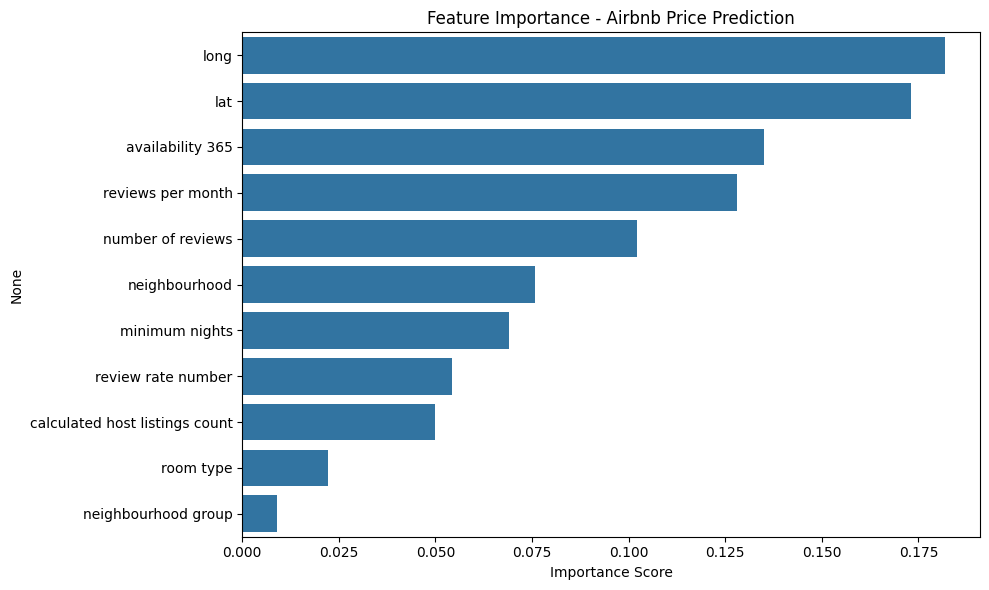

In [16]:
# Feature importance
feature_importance = pd.Series(rf.feature_importances_, index=X_sample.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Feature Importance - Airbnb Price Prediction")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()